In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats

import plot_utils as pu
import styling

import conf.isi5_sweep as cfg

In [2]:
def index(n0, n1):
    return ((n0-n1)/(n0+n1))

In [3]:
def label(STD, TA):
    if STD and TA:
        return 'STD+TA (full model)'
    elif STD:
        return 'STD only'
    elif TA:
        return 'TA only'
    return 'no plasticity'

In [4]:
def get_bspikes(res, episode):
    b = np.zeros(np.asarray(res['raw_dynamics']['v'].shape)[[0,2,3]], bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res['raw_spikes'][episode][f'pulsed_{k}'] for k in 'it'])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        b[i, itrial, t] = True
    return b

In [5]:
plasticity = [(TA, STD) for TA in cfg.TAs for STD in cfg.STDs]
colors = ['C1', 'C2', 'C0', 'k']

In [6]:
nspikes = dd.io.load('nspikes.h5')

ISI = 50, full>sum: Z = 9.5, p = 1
ISI = 100, full>sum: Z = 8, p = 1
ISI = 200, full>sum: Z = -0.01, p = 0.496
ISI = 350, full>sum: Z = -3.4, p = 0.000368
ISI = 500, full>sum: Z = -3.9, p = 4.52e-05
ISI = 750, full>sum: Z = -2.1, p = 0.0188
ISI = 1000, full>sum: Z = -0.38, p = 0.35
ISI = 50, full>0: Z = 9.5, p = 9.86e-22
ISI = 100, full>0: Z = 9.5, p = 9.86e-22
ISI = 200, full>0: Z = 9.5, p = 1.06e-21
ISI = 350, full>0: Z = 8.4, p = 1.73e-17
ISI = 500, full>0: Z = 6.1, p = 4.75e-10
ISI = 750, full>0: Z = 2.5, p = 0.00541
ISI = 1000, full>0: Z = 0.95, p = 0.172


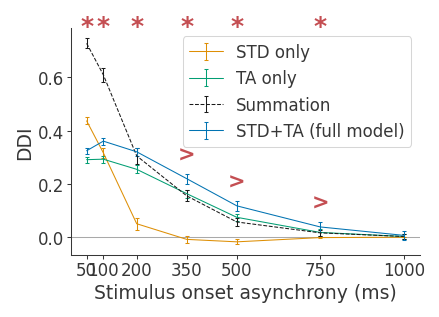

In [7]:
def panel_isi(ax):
    # ddi: (plasticity, isi, network)
    ddi = np.asarray([[index(nspikes[isi][STD][TA]['dev'], nspikes[isi][STD][TA]['msc']) for isi in cfg.ISIs] for TA, STD in plasticity[1:]])
    ddi = np.concatenate([ddi[:2], [ddi[0]+ddi[1]], ddi[2:]])
    labels = ['STD only', 'TA only', 'Summation', 'STD+TA (full model)']
    colors = ['C1', 'C2', 'k', 'C0']
    ymax = [0 for isi in cfg.ISIs]
    sns.set_palette('colorblind')
    for i, pidx in enumerate(ddi):
        mean = np.mean(pidx, 1)
        se = np.std(pidx, 1) / np.sqrt(pidx.shape[1])
        ax.errorbar(cfg.ISIs, mean, yerr=se, label=labels[i], color=colors[i], ls='--' if i ==2 else '-', capsize=1, capthick=.5)
        ymax = np.maximum(ymax, mean+se)
    
    for i, isi in enumerate(cfg.ISIs):
        test = stats.wilcoxon(ddi[2, i], ddi[3, i], method='approx', alternative='less')
        print(f'ISI = {isi}, full>sum: Z = {test.zstatistic:.2g}, p = {test.pvalue:.3g}')
        if test.pvalue < .05:
            ax.text(isi, ymax[i]+0.05, '>', color='r', ha='center', fontsize=10, fontweight='bold')
        
    for i, isi in enumerate(cfg.ISIs):
        test = stats.wilcoxon(ddi[3, i], method='approx', alternative='greater')
        print(f'ISI = {isi}, full>0: Z = {test.zstatistic:.2g}, p = {test.pvalue:.3g}')
        if test.pvalue < .05:
            ax.text(isi, max(ymax)+0.02, '*', color='r', ha='center', **styling.label_kwargs)
    
    ax.axhline(0, **styling.axline_kwargs)
    ax.legend()
    ax.set_xticks(cfg.ISIs)
    ax.tick_params('x')
    ax.set_xlabel('Stimulus onset asynchrony (ms)')
    ax.set_ylabel('DDI')
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(3,2), dpi=150)
panel_isi(ax)

DDI, near != far : t[118] = 0.71, p = 0.479
DDI near, far variance equality : F(2,60) = 9.92, p = 0.00208


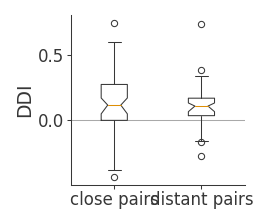

In [8]:
def panel_ddi_stimdist(ax, widths=.3):
    n = nspikes[500][1][1]
    nstims = 2*len(cfg.pairings)
    near, far = [], []
    for ipair, pair in enumerate(cfg.pairings):
        if abs(ord(pair[0]) - ord(pair[1])) == 1:
            output = near
        else:
            output = far
        output.extend([k*nstims + i for k in range(cfg.N_networks) for i in [2*ipair, 2*ipair+1]])
    
    ddi = {}
    for idx, label in ([near, 'close pairs'], [far, 'distant pairs']):
        ddi[label] = index(n['dev'][idx], n['msc'][idx])
    ax.boxplot(ddi.values(), labels=ddi.keys(), notch=True, bootstrap=10000, widths=widths)

    ax.axhline(0, **pu.styling.axline_kwargs)
    ax.set_ylabel('DDI')
    sns.despine(ax=ax)

    test = stats.ttest_ind(ddi['close pairs'], ddi['distant pairs'])
    print(f'DDI, near != far : t[{test.df:n}] = {test.statistic:.3g}, p = {test.pvalue:.3g}')

    test = stats.levene(ddi['close pairs'], ddi['distant pairs'])
    print(f'DDI near, far variance equality : F(2,{len(ddi["close pairs"])}) = {test.statistic:.3g}, p = {test.pvalue:.3g}')

fig, ax = plt.subplots(figsize=(1.5,1.5), dpi=150)
panel_ddi_stimdist(ax)

ISI = 50, full>sum: Z = 9.5, p = 1
ISI = 100, full>sum: Z = 8, p = 1
ISI = 200, full>sum: Z = -0.01, p = 0.496
ISI = 350, full>sum: Z = -3.4, p = 0.000368
ISI = 500, full>sum: Z = -3.9, p = 4.52e-05
ISI = 750, full>sum: Z = -2.1, p = 0.0188
ISI = 1000, full>sum: Z = -0.38, p = 0.35
ISI = 50, full>0: Z = 9.5, p = 9.86e-22
ISI = 100, full>0: Z = 9.5, p = 9.86e-22
ISI = 200, full>0: Z = 9.5, p = 1.06e-21
ISI = 350, full>0: Z = 8.4, p = 1.73e-17
ISI = 500, full>0: Z = 6.1, p = 4.75e-10
ISI = 750, full>0: Z = 2.5, p = 0.00541
ISI = 1000, full>0: Z = 0.95, p = 0.172
DDI, near != far : t[118] = 0.71, p = 0.479
DDI near, far variance equality : F(2,60) = 9.92, p = 0.00208


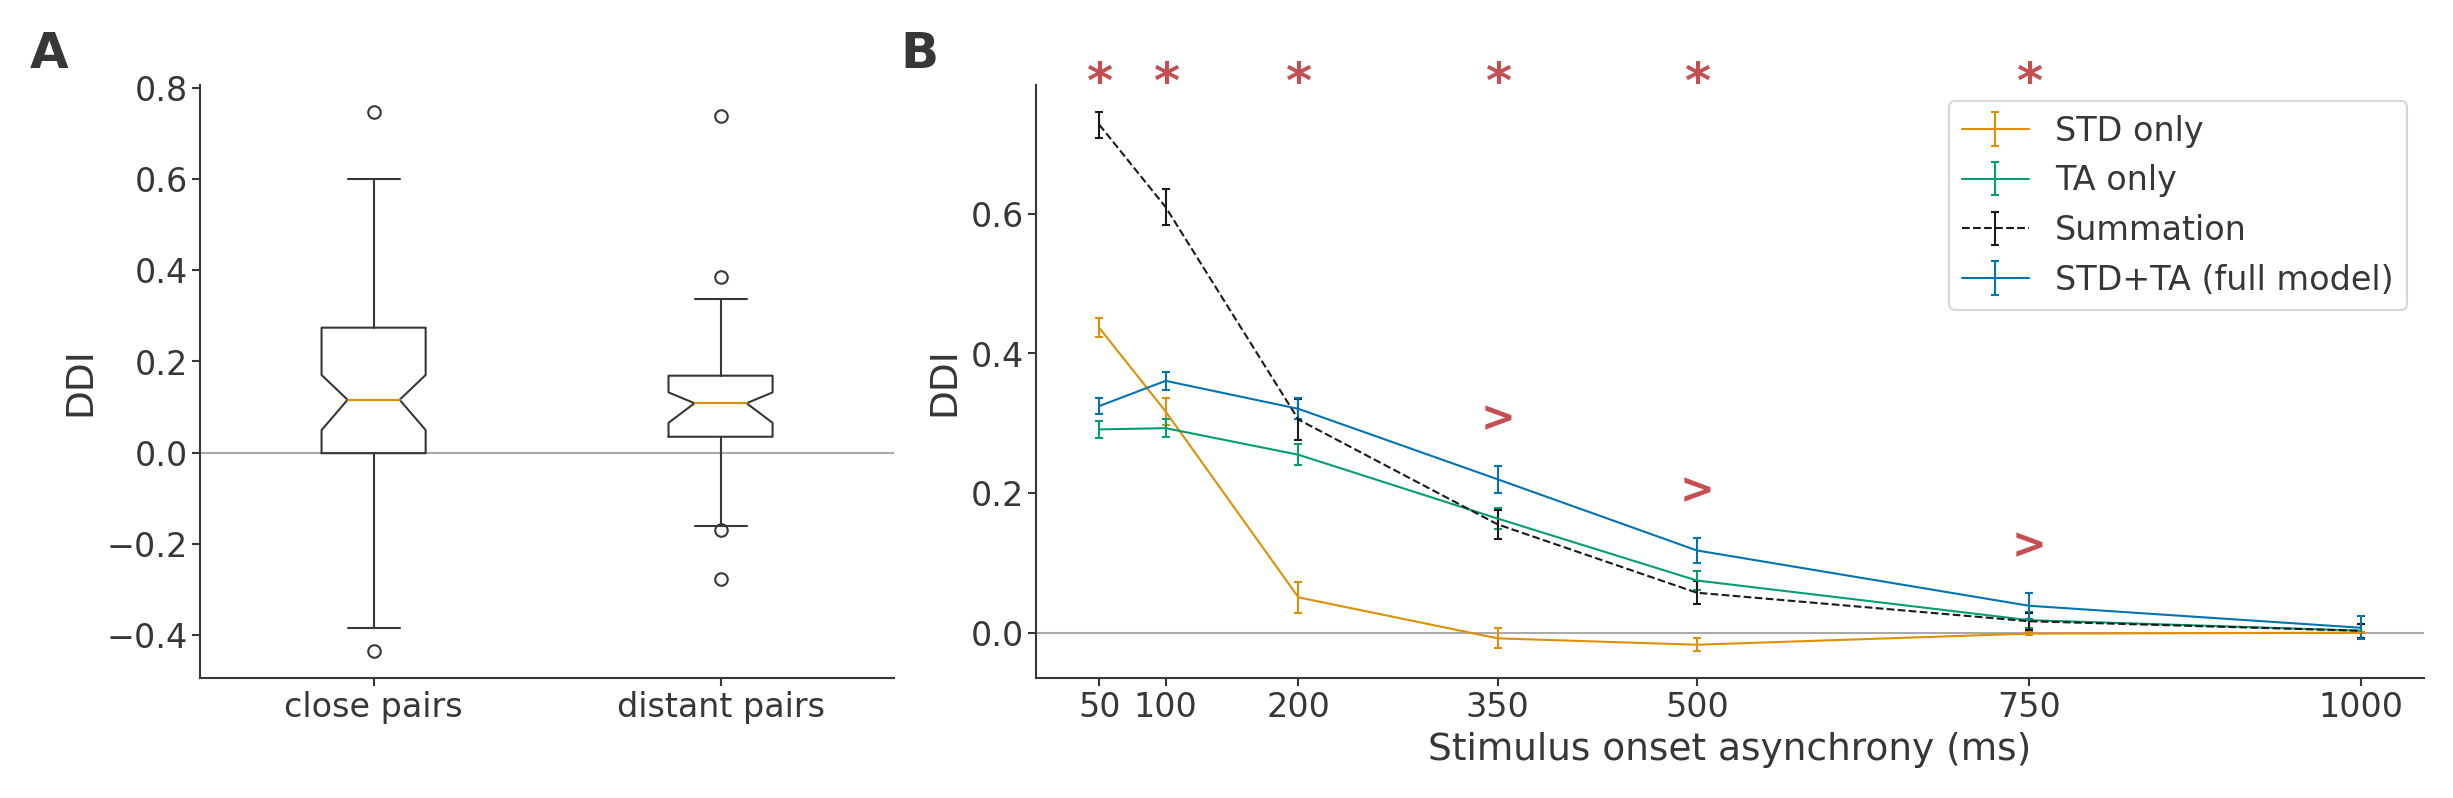

In [9]:
fig = plt.figure(figsize=pu.fullwidth(2), dpi=300, layout='constrained')
gs = fig.add_gridspec(1, 2, width_ratios=(1, 2))

ax = fig.add_subplot(gs[1])
panel_isi(ax)
pu.label_panel(ax, 1)

ax = fig.add_subplot(gs[0])
panel_ddi_stimdist(ax)
pu.label_panel(ax, 0)

plt.savefig('paper-1/Fig10.tif', pil_kwargs={"compression": "tiff_lzw"}, dpi=600)
plt.savefig('paper-1/fig-stimulation-effects.pdf')